In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-7 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.75 # fraction plucked that becomes coarse
theta = 0.75 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 2000000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

100000000.0


In [7]:
Eb

array([1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
      

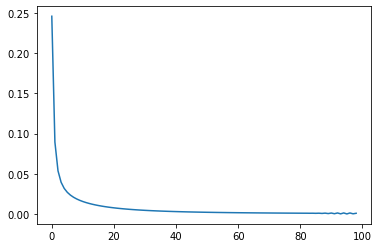

In [8]:
plt.plot(S)

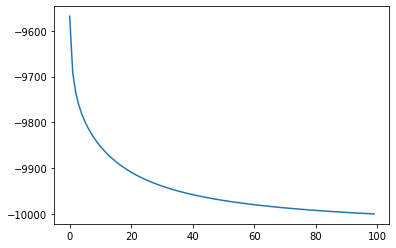

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.000871645414208615

In [11]:
eta

array([-9568.38333341, -9691.43496389, -9736.18959614, -9763.02975964,
       -9782.75279027, -9798.65801099, -9812.12524403, -9823.85910959,
       -9834.27182298, -9843.62920849, -9852.11552068, -9859.86565328,
       -9866.98260414, -9873.54763284, -9879.62651977, -9885.27361497,
       -9890.53456828, -9895.44823722, -9900.04806251, -9904.3630868 ,
       -9908.41872735, -9912.23737425, -9915.83886201, -9919.24084727,
       -9922.45911553, -9925.50783326, -9928.3997574 , -9931.14641097,
       -9933.7582316 , -9936.2446981 , -9938.6144389 , -9940.87532562,
       -9943.03455414, -9945.09871529, -9947.07385662, -9948.96553663,
       -9950.77887265, -9952.51858306, -9954.18902482, -9955.79422679,
       -9957.33791943, -9958.82356143, -9960.25436343, -9961.63330942,
       -9962.96317593, -9964.24654937, -9965.48584161, -9966.68330416,
       -9967.84104095, -9968.96101995, -9970.04508371, -9971.09495898,
       -9972.11226543, -9973.09852368, -9974.05516252, -9974.98352566,
      

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([4.31016666e+02, 3.07965036e+02, 2.63210404e+02, 2.36370240e+02,
       2.16647210e+02, 2.00741989e+02, 1.87274756e+02, 1.75540890e+02,
       1.65128177e+02, 1.55770791e+02, 1.47284479e+02, 1.39534347e+02,
       1.32417396e+02, 1.25852367e+02, 1.19773480e+02, 1.14126385e+02,
       1.08865432e+02, 1.03951763e+02, 9.93519374e+01, 9.50369131e+01,
       9.09812725e+01, 8.71626256e+01, 8.35611379e+01, 8.01591526e+01,
       7.69408843e+01, 7.38921666e+01, 7.10002425e+01, 6.82535889e+01,
       6.56417683e+01, 6.31553018e+01, 6.07855610e+01, 5.85246742e+01,
       5.63654457e+01, 5.43012846e+01, 5.23261433e+01, 5.04344632e+01,
       4.86211272e+01, 4.68814168e+01, 4.52109750e+01, 4.36057731e+01,
       4.20620804e+01, 4.05764384e+01, 3.91456364e+01, 3.77666904e+01,
       3.64368239e+01, 3.51534505e+01, 3.39141583e+01, 3.27166957e+01,
       3.15589589e+01, 3.04389799e+01, 2.93549162e+01, 2.83050409e+01,
       2.72877344e+01, 2.63014762e+01, 2.53448373e+01, 2.44164742e+01,
      